The goal here is to understand the properties of behavioural data and to compare the participants' responses to the responses of simulated agents with planning depth fixed at various levels.

In [8]:
%matplotlib inline
import numpy as np
from scipy import io

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='white')
sns.set_palette("colorblind", n_colors=5, color_codes=True)

from os import listdir
import pandas as pd

import sys
sys.path.append('../')

In [3]:
### load behavioural data ###
from os.path import expanduser
home = expanduser("~")

path = home + '/tudcloud/Shared/Experiments/Plandepth/B03_pilot/main/OA/'  # change to correct path
fnames = listdir(path)

# define order and trial parameters
T = 100
n_subs = len(fnames)
order = np.tile(range(1,5), (25,1)).flatten(order = 'F')
mini_blocks = np.arange(1, T + 1)

# inititate data frame
data = pd.DataFrame(columns = ['gain', 
                               'start_points', 
                               'log_rt_1', 
                               'log_rt_sum', 
                               'subject', 
                               'block_number', 
                               'phase', 
                               'order',
                               'block_index',
                               'end_points'])

states = []
responses = []

for i,f in enumerate(fnames):
    parts = f.split('_')
    tmp = io.loadmat(path+f)
    points = tmp['data']['Points'][0, 0]
        
    # get response times
    rts = np.nan_to_num(tmp['data']['Responses'][0,0]['RT'][0,0])
     
    # get number of trials in each mini-block
    notrials = tmp['data']['Conditions'][0,0]['notrials'][0,0].flatten()
    
    # get points at the last trial of the miniblock
    end_points = points[range(100), (np.nan_to_num(notrials)-1).astype(int)]
    
    states.append(tmp['data']['States'][0,0] - 1)
    responses.append(tmp['data']['Responses'][0,0]['Keys'][0,0] - 1)
    
    start_points = 1000
    df = pd.DataFrame()
    
    df['gain']= np.diff(np.hstack([start_points, end_points]))
    
    df['start_points'] = np.hstack([start_points, end_points])[:-1]
    
    # define log_rt as the natural logarithm of the sum of response times over all trials
    df['log_rt_1']= np.log(rts[:, 0])
    df['log_rt_sum'] = np.log(np.nansum(rts, -1))

    df['subject'] = i + 1
    df['block_number'] = mini_blocks
    
    if notrials[0] == 3:
        df['phase'] = np.hstack([order[50:], order[:50]])
        df['order'] = 2
        df['block_index'] = np.hstack([mini_blocks[50:], mini_blocks[:50]])

    else:
        df['phase'] = order
        df['order'] = 1
        df['block_index'] = mini_blocks
            
    data = data.append(df, ignore_index=True, sort=False)

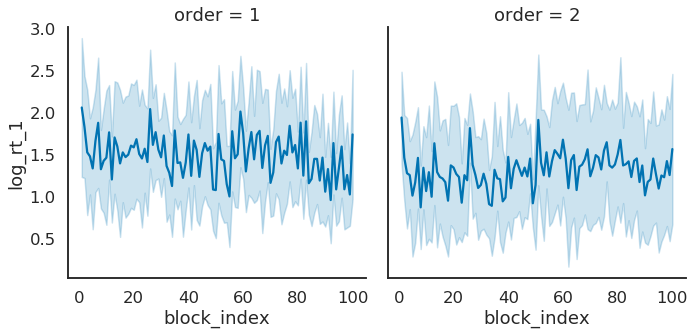

In [4]:
# plot mean of the log(rt_1) with 95% confidence interval or standard deviation
g = sns.FacetGrid(data, col="order", height=5)
g.map(sns.lineplot, "block_index", "log_rt_1", ci="sd");

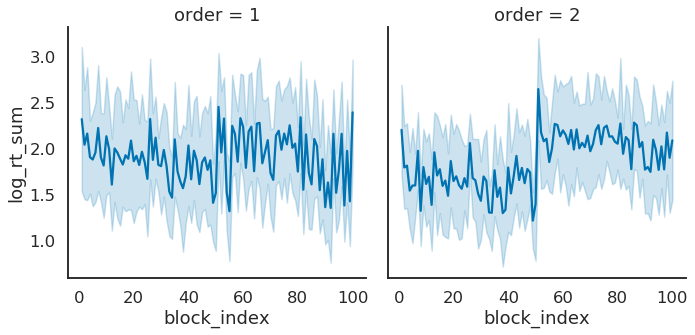

In [5]:
# plot mean of the log(sum rt) 
g = sns.FacetGrid(data, col="order", height=5)
g.map(sns.lineplot, "block_index", "log_rt_sum", ci="sd");

In the plots above order = 1 denotes the experimental sequence in which participants start with 2 trial mini-blocks, and after 50 mini-blocks switch to 3 trial mini-blocks. Order = 2 denotes the reversered order in which participants start with 3 trial mini-blocks. The block index denotes the phase dependent index of a mini-block, where in order 1 condition we are counting blocks from 1 to 100, and in order 2 condition from 
50 to 100, and from 1 to 50. Hence, the above plots are aligned with respect to their condition.

To determine quantities which most influence response times we will perform a linear regression with respect to following predictor variables:
- logarithm of mini-block number 
- phase of the experiment 
- number of points at the beggining of the mini-block

In [5]:
def get_failures(states, responses):
    transitions = np.array([4., 3., 4., 5., 1., 1.])
    n_subs, n_blocks = states.shape[:2]
    
    failures = np.zeros((n_subs, n_blocks))    
    for i in range(n_subs):
        for j in range(2):
            nans = np.isnan(states[i,:,j+1])
            sts = states[i,~nans,j].astype(int)
            matching_trans = transitions[sts] == states[i,~nans, j+1]
            resp = responses[i,~nans,j].astype(bool)
            failures[i,~nans] += np.logical_xor(matching_trans, resp)
        nans = np.isnan(states[i,:,-1])
        failures[i] -= nans
    
    failures[failures < 0] = 0
    return failures

In [6]:
from bayesian_linear_regression import BayesLinRegress

y1 = data['log_rt_1'].values.reshape(n_subs, T).T
y2 = data['log_rt_sum'].values.reshape(n_subs, T).T
X = np.log(np.expand_dims(data['block_number'].values.astype(int).reshape(n_subs, T).T, -1))

phases = data.phase.values.astype(int).reshape(n_subs, T).T - 1
X = np.concatenate([X, np.eye(4)[phases]], -1)

start_points = data.start_points.values.reshape(n_subs, T).T
X = np.concatenate([X, np.expand_dims(start_points, -1)], -1)

m1 = BayesLinRegress(np.swapaxes(X, 0, 1), y1.T)

states = np.array(states)
responses = np.array(responses)
failures = get_failures(states, responses).T

X = np.concatenate([X, np.expand_dims(failures, -1)], -1)

m2 = BayesLinRegress(np.swapaxes(X, 0, 1), y2.T)

samples = []
for m in [m1, m2]:
    samples.append(m.fit(num_samples=5000, warmup_steps=5000, summary=False))
    print('model ppll', m.post_pred_log_likelihood())

sample: 100%|██████████| 10000/10000 [03:34<00:00, 46.71it/s, 255 steps of size 1.36e-02. acc. prob=0.88] 


model ppll -1361.041


sample: 100%|██████████| 10000/10000 [05:29<00:00, 30.33it/s, 511 steps of size 1.06e-02. acc. prob=0.90] 


model ppll -1040.3832


In [7]:
### visualise regression results ###

import numpy as onp

betas = []
for smpl in samples:
    betas.append(onp.array(smpl['beta']).astype(onp.double))

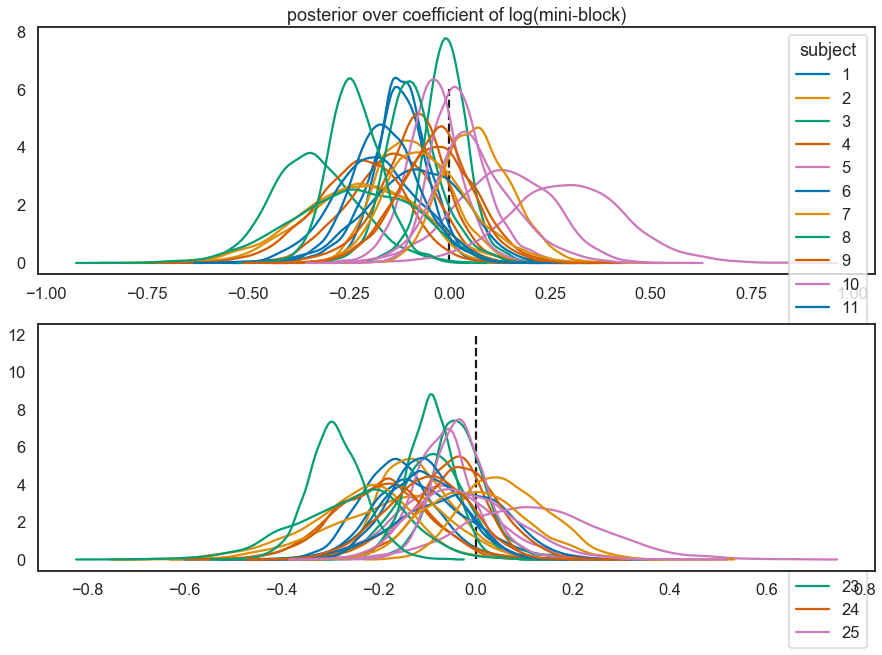

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(len(fnames)):
    sns.kdeplot(betas[0][:, i, 0], label=i+1, ax=ax[0], legend=False)
    sns.kdeplot(betas[1][:, i, 0], label=i+1, ax=ax[1], legend=False)

# ax[0].legend(title='subject');
ax[0].vlines(0, 0, 6, 'k', linestyle='--');
ax[1].vlines(0, 0, 12, 'k', linestyle='--');
ax[0].set_title('posterior over coefficient of log(mini-block)');

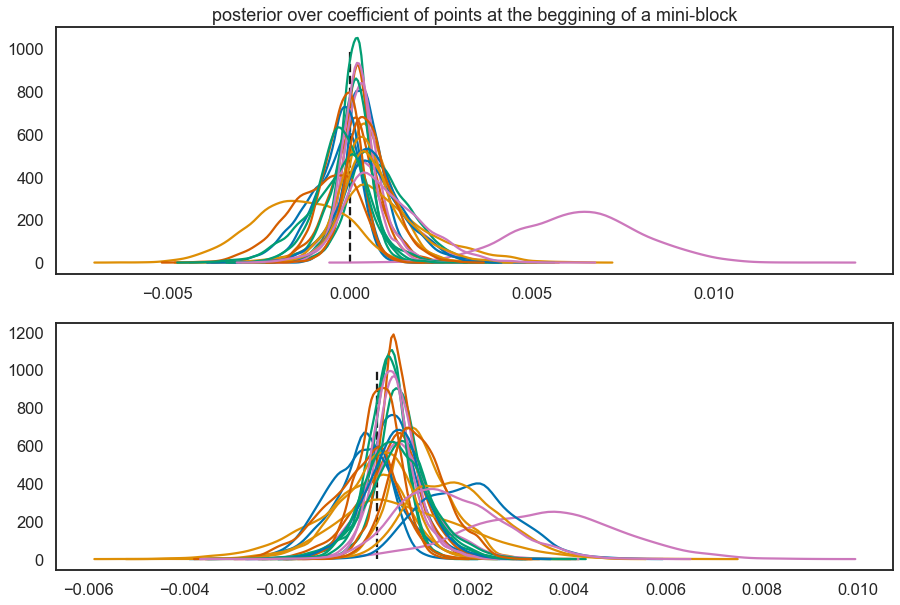

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
for i in range(len(fnames)):
    sns.kdeplot(betas[0][:, i, -1], label=i+1, ax=ax[0], legend=False)
    sns.kdeplot(betas[1][:, i, -2], label=i+1, ax=ax[1], legend=False)

# ax[0].legend(title='subject');
ax[0].vlines(0, 0, 1000, 'k', linestyle='--');
ax[1].vlines(0, 0, 1000, 'k', linestyle='--');
ax[0].set_title('posterior over coefficient of points at the beggining of a mini-block');

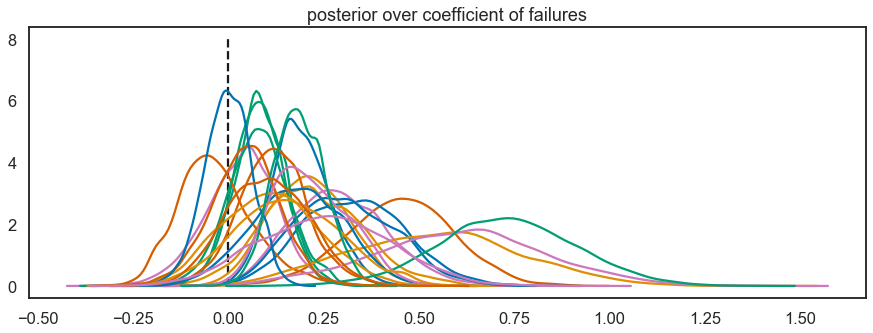

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(len(fnames)):
    sns.kdeplot(betas[1][:, i, -1], label=i+1, legend=False)


# plt.legend(title='subject');
plt.vlines(0, 0, 8, 'k', linestyle='--');
plt.title('posterior over coefficient of failures');

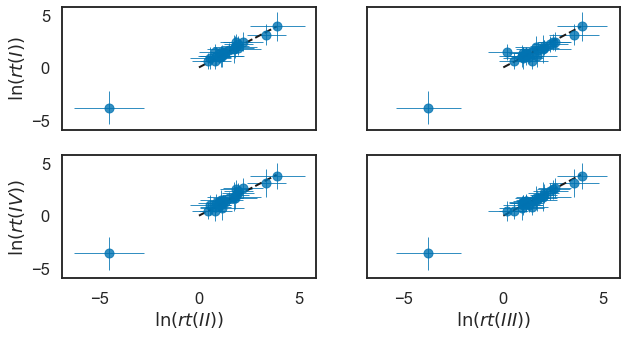

In [64]:
# plot phase coefficients
mu_w = betas[0][..., 1:5].mean(0)
sigma_w = betas[0][..., 1:5].std(0)

fig, ax = plt.subplots(2, 2, figsize = (10, 5), sharey = True, sharex = True)

ax[0,0].errorbar(mu_w[:, 0], mu_w[:, 1], 
                 xerr=sigma_w[:, 0], 
                 yerr=sigma_w[:, 1], 
                 fmt='o',
                 elinewidth = 1,
                 alpha = .8);
ax[0,1].errorbar(mu_w[:, 2], mu_w[:, 1], 
                 xerr=sigma_w[:, 2], 
                 yerr=sigma_w[:, 1], 
                 fmt='o',
                 elinewidth = 1,
                 alpha = .8);
      
ax[1,0].errorbar(mu_w[:, 0], mu_w[:, 3], 
                 xerr=sigma_w[:, 0], 
                 yerr=sigma_w[:, 3], 
                 fmt='o',
                 elinewidth = 1,
                 alpha = .8);

ax[1,1].errorbar(mu_w[:, 2], mu_w[:, 3], 
                 xerr=sigma_w[:, 2],
                 yerr=sigma_w[:, 3],
                 fmt='o',
                 elinewidth = 1,
                 alpha = .8);

ax[0,0].set_ylabel(r'$\ln(rt(I))$')
ax[1,0].set_xlabel(r'$\ln(rt(II))$')
ax[1,0].set_ylabel(r'$\ln(rt(IV))$')
ax[1,1].set_xlabel(r'$\ln(rt(III))$')

x = np.arange(-5., 5., .1)
ax[0,0].plot(x, x, 'k--', lw = 2)
ax[0,1].plot(x, x, 'k--', lw = 2)
ax[1,0].plot(x, x, 'k--', lw = 2)
ax[1,1].plot(x, x, 'k--', lw = 2)
axes[0, 0].set_x

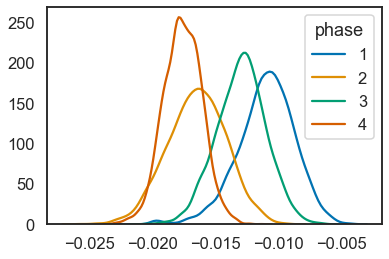

In [63]:
# sns.kdeplot(onp.array(samples[0]['m']).T)
smpl = onp.array(samples[0]['m'])
for i in range(1, smpl.shape[-1] - 1):
    sns.kdeplot(smpl[:, i], label=i)
    
plt.legend(title='phase')

Overal we see more structure in the estimates of the regression coefficients when using log of the sum of response times instead of the first response time, as a response variable.

## Simulated behaviour
In what follows we will compare subjects preformance with the performance of simulated agents

In [9]:
import torch

from tasks import SpaceAdventure
from agents import BackInduction
from simulate import Simulator

exp = io.loadmat('../experiment/experimental_variables_new.mat')
starts = exp['startsExp'][:, 0] - 1
planets = exp['planetsExp'] - 1
vect = np.eye(5)[planets]

# setup parameters for the task environment
runs = 50
blocks = 100
na = 2
ns = 6
no = 5

ol1 = torch.from_numpy(vect)
ol2 = torch.from_numpy(np.vstack([vect[50:], vect[:50]]))

starts1 = torch.from_numpy(starts)
starts2 = torch.from_numpy(np.hstack([starts[50:], starts[:50]]))
    
noise = np.tile(np.array([0, 1, 0, 1]), (25,1)).T.flatten()
trials1 = np.tile(np.array([2, 2, 3, 3]), (25,1)).T.flatten()
trials2 = np.tile(np.array([3, 3, 2, 2]), (25,1)).T.flatten()

costs = torch.FloatTensor([-2, -5])  # action costs
fuel = torch.arange(-20., 30., 10.)  # fuel reward of each planet type

confs = torch.stack([ol1, ol2])
confs = confs.view(2, 1, blocks, ns, no).repeat(1, runs//2, 1, 1, 1)\
        .reshape(-1, blocks, ns, no).float()

starts = torch.stack([starts1, starts2])
starts = starts.view(2, 1, blocks).repeat(1, runs//2, 1)\
        .reshape(-1, blocks)
        
conditions = torch.zeros(2, runs, blocks, dtype=torch.long)
conditions[0] = torch.tensor(noise, dtype=torch.long)[None,:]
conditions[1, :runs//2] = torch.tensor(trials1, dtype=torch.long)
conditions[1, runs//2:] = torch.tensor(trials2, dtype=torch.long)

In [10]:
# iterate over different planning depths
agents = []
simulations = []
performance = []
for depth in range(3):
    
    # define space adventure task with aquired configurations
    # set number of trials to the max number of actions
    space_advent = SpaceAdventure(conditions,
                                  outcome_likelihoods=confs,
                                  init_states=starts,
                                  runs=runs,
                                  mini_blocks=blocks,
                                  trials=3)
    
    # define the optimal agent, each with a different maximal planning depth
    agent = BackInduction(confs,
                          runs=runs,
                          mini_blocks=blocks,
                          trials=3,
                          planning_depth=depth+1)
    
    agent.set_parameters()
    
    # simulate experiment
    sim = Simulator(space_advent, 
                    agent, 
                    runs=runs, 
                    mini_blocks=blocks,
                    trials=3)
    sim.simulate_experiment()
    
    simulations.append(sim)
    agents.append(agent)
    
    responses = sim.responses.clone()
    responses[torch.isnan(responses)] = 0
    responses = responses.long()
    
    outcomes = sim.outcomes
    
    points = costs[responses] + fuel[outcomes]
    points[outcomes<0] = 0
    performance.append(points.sum(-1))

In [88]:
sim_data = pd.DataFrame()
rel_score = np.zeros((3, 4))
for depth in range(3):
    start_points = 1000
    end_points = start_points + performance[depth].numpy().cumsum(-1)
    points = np.hstack([start_points*np.ones((runs, 1)), end_points])
    df = pd.DataFrame(points.T, columns=range(runs))
    df['mini-block'] = np.arange(101)
    df = pd.melt(df, id_vars='mini-block', value_vars=range(runs), value_name='points')
    df['order'] = 1
    df.loc[df.variable >= 25, 'order'] = 2
    df['depth'] = depth + 1
    sim_data = sim_data.append(df, ignore_index=True)
    
    phase_values = np.concatenate([start_points*np.ones((50, 1)), end_points.reshape(-1, 4, 25)[..., -1]], -1)
    diffs = np.diff(phase_values, axis=-1)
                    
    diffs[25:, :] = np.concatenate([diffs[25:, 2:], diffs[25:, :2]], -1) 
    
    rel_score[depth] = diffs.mean(0)/25

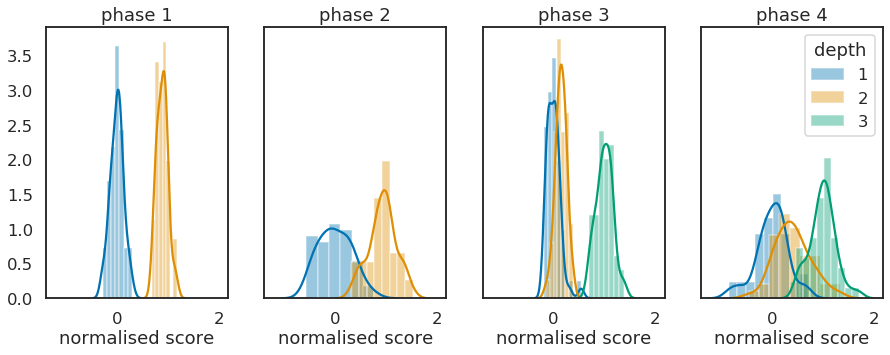

In [114]:
import seaborn as sns
norm_score = np.zeros((3, 50, 4))
for depth in range(3):
    df = sim_data.loc[sim_data.depth == depth+1]
    end_points = df['points'].values.reshape(50, -1)[:, 1:]
    
    end_phase_points = np.concatenate([start_points*np.ones((50, 1)), end_points.reshape(-1, 4, 25)[..., -1]], -1)
    phase_diffs = np.diff(end_phase_points, axis=-1)
    
    phase_diffs[25:, :] = np.concatenate([phase_diffs[25:, 2:], phase_diffs[25:, :2]], -1) 
    
    norm_score[depth] = (phase_diffs/25 - rel_score[0])/(rel_score[-1] - rel_score[0])

fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)

for i in range(4):
    axes[i].set_title('phase {}'.format(i + 1))
    axes[i].set_xlabel('normalised score')
    for d in range(3):
        if i < 2:
            if d < 2:
                sns.distplot(norm_score[d, :, i].T, ax=axes[i])
        else:
            sns.distplot(norm_score[d, :, i].T, ax=axes[i])
        
axes[-1].legend([1, 2, 3], title='depth')
fig.savefig('simulates_normalised_scores.pdf', dpi=300)

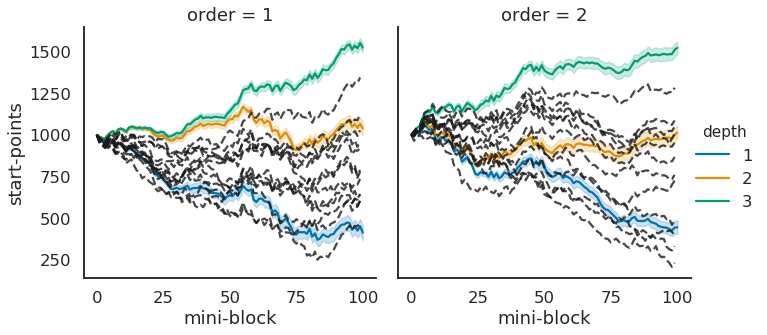

In [83]:
g = sns.FacetGrid(sim_data, col="order", hue='depth', height=5)
g.map(sns.lineplot, "mini-block", "start-points").add_legend();

for order in range(2):
    for subject in np.unique(data.subject.values):
        df = data.loc[data.order == order+1]
        points = df.loc[df.subject == subject]['start_points'].values
        if len(points) == blocks:
            g.axes[0, order].plot(mini_blocks - 1, points, 'k--', alpha=.8)

In the above plot we are comparing point counts of individual subjects (dashed black lines) with the mean performance of agents with fixed planning depth. Visual inspection sudjest that in the first group of participants (order = 1) one of the participants eventually behaved as agent of planning depth 3, while the other two are mostly behaving as planning depth 1 agents. In the second group (order = 2) we have one participant which was performing in the range between planning depth 2 and 3 agents and another with low planning depth of 1. Overal, this results suggest that old adults are able to performe the task to certain degree but that we should expect large variability in performance (I would expect in the control group performance variability to be much smaller).

MannwhitneyuResult(statistic=303.0, pvalue=0.430686896227776)
MannwhitneyuResult(statistic=180.0, pvalue=0.005214998448103857)
MannwhitneyuResult(statistic=224.0, pvalue=0.043869147531070365)
MannwhitneyuResult(statistic=258.0, pvalue=0.14737020680392754)
WilcoxonResult(statistic=155.0, pvalue=0.8400716444402775)
WilcoxonResult(statistic=39.0, pvalue=0.0008905376442220464)
WilcoxonResult(statistic=83.0, pvalue=0.032427612126453696)
WilcoxonResult(statistic=99.0, pvalue=0.08752712680268941)


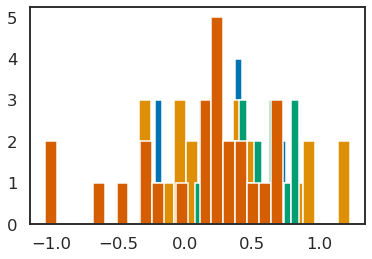

In [79]:
score = data['gain'].values.reshape(n_subs, 4, -1).sum(-1)/25
order = data.order.values.reshape(n_subs, -1)[:, 0]
rev = order == 2

score[rev] = np.concatenate([score[rev, 2:], score[rev, :2]], -1)

norm_score = (score - rel_score[0])/(rel_score[-1] - rel_score[0])

for i in range(4):
    plt.hist(norm_score[:, i], bins=20)

from scipy.stats import mannwhitneyu, wilcoxon

print(mannwhitneyu(norm_score[:, 0], norm_score[:, 1]))
print(mannwhitneyu(norm_score[:, 2], norm_score[:, 3]))
print(mannwhitneyu(norm_score[:, 0], norm_score[:, 2]))
print(mannwhitneyu(norm_score[:, 1], norm_score[:, 3]))

print(wilcoxon(norm_score[:, 0], norm_score[:, 1]))
print(wilcoxon(norm_score[:, 2], norm_score[:, 3]))
print(wilcoxon(norm_score[:, 0], norm_score[:, 2]))
print(wilcoxon(norm_score[:, 1], norm_score[:, 3]))

In [115]:
rel_score

array([[-10.788 ,  -3.6888,  -9.5272,   1.1344],
       [ -0.6512,   4.388 ,  -7.2688,   4.556 ],
       [  0.5608,   4.9912,   5.9328,   9.516 ]])